#Sativa

Sativa does a number of useful things, including checking the reference database for putatively mis-labelled sequences. Let's try it first on the positives database (which is small) and then on the main reference database (which is not!).

We already have downloaded the relevant .gb files, so let's copy them to this location first.

In [263]:
!cp ../positives_curated.gb $(pwd)

In [195]:
!cp ../eyorks_flora_curated.gb $(pwd)

^C


In [264]:
ls

alignment.phy                         rbcL.log
eyorks_flora_curated.gb               rbcL@mafftLinsi_aln_clipped.phy
loci_counts.txt                       rbcL@mafftLinsi_aln.fasta
loci.csv                              rbcL.mis
mafftLinsi-clipped-raxml.html         rbcL_nr_pre_Sativa.gb
mafftLinsi-clipped-raxml-SATIVA.html  rbcL_nr_pre_Sativa_pos.gb
nr.pkl                                rbcL.refjson
nr.pkl1                               sativa/
positives_curated.gb                  Sativa.ipynb
raw.pkl                               Sativa_pos_prep.ipynb
raw.pkl1                              species_vs_locus_raw.csv
rbcL_cropped_pos.fa                   target_locus.csv
rbcL_cropped_pos.gb                   taxa.csv
rbcL.final_epa.jplace                 tax_for_SATIVA.tax
rbcL_id-1.uc                          taxids.txt
rbcL.l1out_seq.jplace


#Positive control reference db

Read reference sequences into ReproPhylo and filter to keep only proper rbcL records.

In [304]:
from reprophylo import *

In [305]:
list_loci_in_genbank('positives_curated.gb',
                     'loci.csv',
                     'loci_counts.txt')

In [306]:
!cat loci_counts.txt


There are 1 gene names (or gene product names) detected
----------------------------------
Gene and count sorted by gene name
----------------------------------
17 instances of CDS,rbcL
-------------------------------
Gene and count sorted by counts
-------------------------------
17 instances of CDS,rbcL


In [307]:
!cat loci.csv

dna,CDS,rbcL,rbcL


In [308]:
%%file target_locus.csv
dna,CDS,rbcL,rbcL,1

Overwriting target_locus.csv


In [309]:
!cat target_locus.csv

dna,CDS,rbcL,rbcL,1

Start ReproPhylo project.

In [310]:
#first time only
#pj=Project('target_locus.csv', pickle='raw.pkl2', git=False)

In [272]:
pj = unpickle_pj('raw.pkl1', git=False)

Read sequences into ReproPhylo.

In [311]:
pj.read_embl_genbank(['positives_curated.gb'])

In [312]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


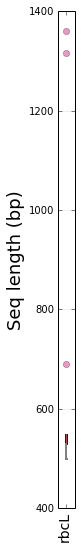

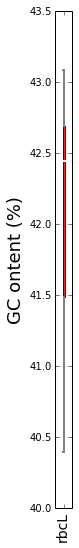

In [313]:
%matplotlib inline
pj.report_seq_stats()

In [314]:
pj.species_vs_loci('species_vs_locus_raw.csv')

In [315]:
!cat species_vs_locus_raw.csv

In [316]:
species=[]
for r in pj.records:
    source = [f for f in r.features if f.type == 'source'][0]
    species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print species

Total number of records: 17
Number of species (see below for full list): 8
['Crassula perforata', 'Dracaena fragrans', 'Kalanchoe pinnata', 'Dracaena aletriformis', 'Dracaena transvaalensis', 'Dracaena mannii', 'Crassula nudicaulis', 'Dracaena draco']


In [317]:
def crop_to_CDS(record):
    """The function crops a Genbank record to only retain the sequnence of the first CDS"""
    
    from Bio import SeqFeature
    
    strands=[]
    r = record
    print "\nprocessing record: '%s' " %r.id,
    if r.features:
        for feature in r.features:
            if feature.type == 'CDS':
                strands.append(feature.location.strand)
                gene_name = feature.qualifiers['gene'][0]
                r.seq = r.seq[feature.location.start:feature.location.end]
                feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(0), 
                                                              SeqFeature.ExactPosition(feature.location.end - feature.location.start), 
                                                             1)
                break
                
        for feature in r.features:
            if feature.type == 'source':
                strands.append(feature.location.strand)
                feature.qualifiers['note'] = ['modified from original record: cropped to only CDS of '+gene_name]
                feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(0), 
                                                              SeqFeature.ExactPosition(len(r.seq)), 
                                                             feature.location.strand)
                break
                    
        if len(list(set(strands))) > 1:
            r.seq = r.seq.reverse_complement()
            print "\t.. reverse complementing",

        print "\t.. final length: %s" %len(r.seq),

    else:
        print "\t  no features found .."

    #print r.format('genbank')


In [318]:
for r in pj.records:
    crop_to_CDS(record=r)


processing record: 'JX571820.1'  	.. final length: 552 
processing record: 'JQ591185.1'  	.. final length: 552 
processing record: 'JF265398.1'  	.. final length: 503 
processing record: 'JX572538.1'  	.. final length: 535 
processing record: 'JQ591186.1'  	.. final length: 552 
processing record: 'GU135277.1'  	.. final length: 499 
processing record: 'KP208892.1'  	.. final length: 538 
processing record: 'AB029848.1'  	.. final length: 1360 
processing record: 'JX572540.1'  	.. final length: 552 
processing record: 'JQ591187.1'  	.. final length: 552 
processing record: 'JQ591188.1'  	.. final length: 526 
processing record: 'AF274594.1'  	.. final length: 1317 
processing record: 'JQ734500.1'  	.. final length: 511 
processing record: 'JQ591189.1'  	.. final length: 552 
processing record: 'HM849958.1'  	.. final length: 691 
processing record: 'JX572539.1'  	.. final length: 530 
processing record: 'KP110251.1'  	.. final length: 552


Write cropped records (minimum length 499bp) to Genbank file. At this point we could manually exclude some accession numbers - we will do this for the main reference db, but not now.

In [319]:
from Bio import SeqIO

temp=[]
for r in pj.records:
    if len(r.seq) >= 499:
        temp.append(r)
        
out = open('rbcL_cropped_pos.gb', 'w')
SeqIO.write(temp, out, 'genbank')
out.close()

out = open('rbcL_cropped_pos.fa', 'w')
SeqIO.write(temp, out, 'fasta')
out.close()


del(temp)

Pickle the project.

In [320]:
pickle_pj(pj, 'raw.pkl2')

'raw.pkl2'

#Remove redundancy and tree building

Remove redundancy by clustering the rbcL sequences with vsearch

In [321]:
!vsearch -threads 5 --cluster_fast rbcL_cropped_pos.fa --strand both --uc rbcL_id-1.uc --id 1 --query_cov 1

vsearch v1.1.0_linux_x86_64, 31.4GB RAM, 12 cores
https://github.com/torognes/vsearch

Reading file rbcL_cropped_pos.fa 100%
10874 nt in 17 seqs, min 499, max 1360, avg 640
Indexing sequences 100%
Masking 100%
Sorting by length 100%
Counting unique k-mers 100%
Clustering 100%
Writing clusters 100%
Clusters: 12 Size min 1, max 5, avg 1.4
Singletons: 10, 58.8% of seqs, 83.3% of clusters


In [322]:
#first time only
#pj = Project('target_locus.csv', pickle='nr.pkl3', git=False)

In [237]:
pj = unpickle_pj('nr.pkl', git=False)

In [323]:
pj.read_embl_genbank(['rbcL_cropped_pos.gb'])

In [324]:
pj.extract_by_locus()

Distribution Of Sequence Lengths
Distribution Of Sequence Statistic "Gc_Content"


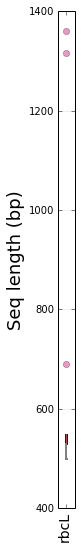

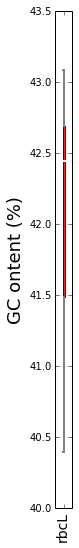

In [325]:
%matplotlib inline
pj.report_seq_stats()

In [326]:
species=[]
for r in pj.records:
    source = [f for f in r.features if f.type == 'source'][0]
    species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print species

Total number of records: 17
Number of species (see below for full list): 8
['Crassula perforata', 'Dracaena fragrans', 'Kalanchoe pinnata', 'Dracaena aletriformis', 'Dracaena transvaalensis', 'Dracaena mannii', 'Crassula nudicaulis', 'Dracaena draco']


Extract IDs of representative sequences identified by vsearch -> remove all others from the object

In [327]:
ids = []

uc=open('rbcL_id-1.uc', 'r')

for line in uc:
    if line.startswith('C'):
        ids.append(line.split("\t")[8])
        
recs_to_keep = {'rbcL': ids}
recs_to_drop = {'rbcL': []}

for r in pj.records:
    if not r.id in recs_to_keep['rbcL']:
        recs_to_drop['rbcL'].append(r.id)
        
print "to drop: %s" %len(recs_to_drop['rbcL'])
print "to keep: %s" %len(recs_to_keep['rbcL'])

print "TOTAL: %s" %(len(recs_to_drop['rbcL']) + len(recs_to_keep['rbcL']))

to drop: 5
to keep: 12
TOTAL: 17


Here is another point at which we could theoretically manually remove our blacklist, by appending accession numbers to the 'recs_to_keep' list.
We're not doing that for this db, so let's just exclude the redundant records now.

In [328]:
pj.exclude(start_from_max=False, **recs_to_drop)

In [329]:
species=[]
for r in pj.records:
    if r.id in recs_to_keep['rbcL']:
        source = [f for f in r.features if f.type == 'source'][0]
        species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
    
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print species

Total number of records: 12
Number of species (see below for full list): 8
['Crassula perforata', 'Dracaena fragrans', 'Kalanchoe pinnata', 'Dracaena aletriformis', 'Dracaena transvaalensis', 'Dracaena mannii', 'Crassula nudicaulis', 'Dracaena draco']


Write full Genbank records to file for later processing with SATIVA.

In [330]:
seqs = []
from Bio import SeqIO
for r in pj.records:
    if r.id in recs_to_keep['rbcL']:
        seqs.append(r)

out = open('rbcL_nr_pre_Sativa_pos.gb','w')
SeqIO.write(seqs, out, 'genbank')
out.close()

Configure Alignment.

In [331]:
mafft_linsi = AlnConf(pj,                              # The Project
                    method_name='mafftLinsi',        # Any unique method name,
                    CDSAlign=True,                   # Use this method to align
                    codontable=2,                    # The genetic code that
                    program_name='mafft',            # mafft or muscle.
                    cmd='mafft',                     # The command on your machine
                    loci=['rbcL'],                 # A list of loci names to align.vel.
                    cline_args={'localpair': True,# Program specific keywords and arguments.
                                'maxiterate': 1000}# cine_args=={} by default, which will
                    )

mafft --localpair --maxiterate 1000 333861477316008.61_CDS_proteins_rbcL.fasta


Perform alignment

In [332]:
pj.align([mafft_linsi])

In [333]:
print pj.used_methods['mafftLinsi']

AlnConf named mafftLinsi with ID 333861477316008.61
Loci: rbcL 
Created on: Mon Oct 24 13:33:28 2016
Commands:
rbcL: mafft --localpair --maxiterate 1000 333861477316008.61_CDS_proteins_rbcL.fasta

Environment:
Platform: Linux-4.4.0-45-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: BioPC5
 Program and version: MAFFT v7.123b\nPal2Nal v14
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution time:
0.36677098274

In [334]:
pickle_pj(pj, 'nr.pkl3')

'nr.pkl3'

In [335]:
pj.write_alns(id=['record_id','source_organism'], format='fasta')

['rbcL@mafftLinsi_aln.fasta']

Alignment looks ok. Needs a bit of end clipping. TrimAL, the trimming method implemented in ReproPhylo doesn't seem to allow for end clipping only, so the below cell contains a custom solution for start/end-clipping the alignment.

We only want to trim the alignment from the end because this is the alignment that should be used for phylogenetic placement and it needs to be possible to align reads to the alignment.

Clipping positions are determined from start/end of the alignment by assessing the average per column completeness across 10 bp sliding windows. per column completeness is the proportion of sequences represented by ACGT in a given column. Average completeness is assessed across 10bp sliding windows.

The clipping point is defined as the position at which the alignment, starting from the 5'/3'-ends, respectively, retained an average completeness > 0.7 (i.e. 70% of the sequences are informative) for 10 consecutive sliding windows.

In [336]:
import numpy as np

per_col=[]

aln = pj.fa('rbcL@mafftLinsi')


icol=0
for a in aln[1,:]:
    ACGT_count=0
    col=aln[:,icol]
    for i in range(len(col)):
        if col[i] in ['A','G','C','T']:
            ACGT_count+=1
#    print pj.fa('CytB@mafftLinsi')[:,a]
    per_col.append(float(ACGT_count)/len(col))
    icol+=1

wsize=10
min_prop=0.7
    
print "\nFinding forward clip position:\n"
forw_count=0
forw_clip=0
for i in range(len(per_col)-wsize):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        forw_count+=1
        forw_clip=i
        print forw_count,i,np.mean(per_col[i:i+wsize])
    else:
        forw_count=0
        
    if forw_count >= wsize:
        break
        
print "Suggested forward clip at: %s (%s,%s)" %(forw_clip-wsize,forw_count,forw_clip)

print "\nFinding reverse clip position:\n"
reve_count=0
reve_clip=0
for i in reversed(range(len(per_col)-wsize)):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        reve_count+=1
        reve_clip=i
        print reve_count,i,np.mean(per_col[i:i+wsize])
    else:
        reve_count=0
        
    if reve_count >= wsize:
        break
    
print "Suggested reverse clip at: %s (%s,%s)" %(reve_clip+wsize,reve_count,reve_clip)

returning alignment object rbcL@mafftLinsi

Finding forward clip position:

1 17 0.708333333333
2 18 0.716666666667
3 19 0.725
4 20 0.733333333333
5 21 0.741666666667
6 22 0.741666666667
7 23 0.741666666667
8 24 0.758333333333
9 25 0.775
10 26 0.8
Suggested forward clip at: 16 (10,26)

Finding reverse clip position:

1 541 0.7
2 540 0.716666666667
3 539 0.733333333333
4 538 0.75
5 537 0.766666666667
6 536 0.791666666667
7 535 0.816666666667
8 534 0.841666666667
9 533 0.866666666667
10 532 0.875
Suggested reverse clip at: 542 (10,532)


Clip the alignment at the positions determined above and write to file. We'll use Biopython functions to do this.

Clip alignment - the new Biopython alignment object is called clipped_aln.

In [337]:
from Bio import AlignIO

aln = pj.fa('rbcL@mafftLinsi')

clipped_aln = aln[:,forw_clip-wsize:reve_clip+wsize]

returning alignment object rbcL@mafftLinsi


Convert the clipped alignment (which is a Biopython alignment object) to a ReproPhylo trimmed alignment object, so that we can resume working with it in ReproPhylo.

In [351]:
pj.trimmed_alignments["rbcL@mafftLinsi_aln_clipped"] = clipped_aln

In [353]:
pj.trimmed_alignments

{'rbcL@mafftLinsi_aln_clipped': <<class 'Bio.Align.MultipleSeqAlignment'> instance (12 records of length 526, SingleLetterAlphabet()) at 7f54d18bc590>,
 'rbcl@mafftLinsi_aln_clipped': <<class 'Bio.Align.MultipleSeqAlignment'> instance (12 records of length 526, SingleLetterAlphabet()) at 7f54d18bc590>}

Write clipped alignment to file for downstream taxonomic curation using SATIVA.

In [354]:
from Bio import AlignIO

out=open('rbcL@mafftLinsi_aln_clipped.phy', 'w')
AlignIO.write(clipped_aln, out, 'phylip-relaxed')
out.close()

Actually running SATIVA is best done in its own notebook, so let's divert now to that, and then continue with this notebook.

Infer Maximum Likelihood tree based on the clipped alignment. We are going to use RAxML.

Configure RAxML.

In [355]:
raxml = RaxmlConf(pj, method_name='raxml-mafftLinsi-clipped',
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['rbcL@mafftLinsi_aln_clipped'],
                 model='GAMMA',
                 threads=5,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 458021477317007.09_rbcL@mafftLinsi_aln_clipped0 -p 497 -s 458021477317007.09_rbcL@mafftLinsi_aln_clipped.fasta -T 5 -x 127 -N 100


Run RAxML.

In [356]:
pj.tree([raxml])

In [357]:
print pj.used_methods['raxml-mafftLinsi-clipped']

RaxmlConf named raxml-mafftLinsi-clipped with ID 458021477317007.09
Alignments: rbcL@mafftLinsi_aln_clipped 
Created on: Mon Oct 24 13:50:07 2016
Commands:
rbcL@mafftLinsi_aln_clipped:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 458021477317007.09_rbcL@mafftLinsi_aln_clipped0 -p 497 -s 458021477317007.09_rbcL@mafftLinsi_aln_clipped.fasta -T 5 -x 127 -N 100

Environment:
Platform: Linux-4.4.0-45-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: BioPC5
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution time:
1.70503115654

Core Methods section sentence:
Phylog

In [358]:
pickle_pj(pj, 'nr.pkl3')

'nr.pkl3'

Now let's visualize the tree.

Prepare tree annotation:

- define outgroups
- specify support coloration

In [359]:
pj.add_qualifier_from_source('organism')

In [360]:
for species in ['Kalanchoe','Crassula']:
    pj.if_this_then_that(species, 'organism', 'outgroup','outgroup',
                        mode='part')

In [361]:
supports = {'black': [100,95],
           'dimgray': [95,75],
           'silver': [75,50]}

In [362]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup','outgroup',
            ['source_organism','record_id'],
            node_support_dict=supports, multifurc=10,
            html='mafftLinsi-clipped-raxml.html')


Check tree out. Have a think which sequences you would consider mislabelled and should better be removed from the reference database.

Create a static copy of the tree (the last *.png with the expected alignment id) for later.

In [363]:
%%bash

last_png=$(ls -hlrt *rbcL@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rbcL_mafftLinsi_clipped_raxml.png

#============================

In the meantime we have run SATIVA on the alignment that was the basis of the above tree.

Now we are going to highlight the records that SATIVA considers mislabelled in the tree. We are also going to add a heatmap to the tree illustrating the confidence that SATIVA has in a given call.

Parse SATIVA output and record putatively mislabelled sequence records and the confidence of the call.

In [364]:
rec_mislabelled = {}
sativa=open('rbcL.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]

Add two new qualifiers containing info about the SATIVA results to the sequence features.

In [365]:
for r in pj.records:
    if r.id in rec_mislabelled:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['yes']
            f.qualifiers['mislabeled_conf'] = [rec_mislabelled[r.id]]
    else:
        for f in r.features:
            f.qualifiers['mislabeled'] = ['no']
            f.qualifiers['mislabeled_conf'] = [0.0001]

In [366]:
pj.propagate_metadata()

Prepare tree annotation:
- color records that were identified by SATIVA as being mislabelled.
- add heatmap with mislabel confidence    

In [367]:
leaf_colors = {'yes':'red', 'no': 'black'}
bg_colors = {'yes': 'red', 'no': 'white'}

In [370]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='mafftLinsi-clipped-raxml-SATIVA.html',
            fsize=13,
            heat_map_meta = ['mislabeled_conf'], heat_map_colour_scheme = 1,
            leaf_node_color_meta = 'mislabeled', leaf_label_colors = leaf_colors)

In [371]:
%%bash

last_png=$(ls -hlrt *rbcL@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rbcL_mafftLinsi_clipped_raxml_SATIVA_leaf_colored.png

In [372]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=10,
            html='mafftLinsi-clipped-raxml-SATIVA.html',
            fsize=13,
            heat_map_meta = ['mislabeled_conf'], heat_map_colour_scheme = 1,
            node_bg_meta = 'mislabeled', node_bg_color = bg_colors)

In [373]:
%%bash

target=rbcL_mafftLinsi_clipped_raxml_SATIVA_bg_colored.png

last_png=$(ls -hlrt *rbcL@mafftLinsi_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png $target

Have a look - Dracaena aletriformis seems to have been flagged.

In [375]:
pickle_pj(pj, 'nr.pkl3')

'nr.pkl3'

#Post-SATIVA

We now want to exclude records SATIVA doesn't like, and redo alignment and tree-building

In [436]:
pj=Project('target_locus.csv', pickle='post_SATIVA_pos1.pkl', git=False)

In [437]:
pj.read_embl_genbank(['rbcL_nr_pre_Sativa_pos.gb'])

In [438]:
pj.extract_by_locus()

Set the stage:

In [439]:
recs_to_keep = {'rbcL': []}
recs_to_drop = {'rbcL': []}

print "to drop: %s" %len(recs_to_drop['rbcL'])
print "to keep: %s" %len(recs_to_keep['rbcL'])

print "TOTAL: %s" %(len(recs_to_drop['rbcL']) + len(recs_to_keep['rbcL']))

to drop: 0
to keep: 0
TOTAL: 0


Record all record IDs and assign them the status 'keep'

In [440]:
for r in pj.records_by_locus['rbcL']:
    recs_to_keep['rbcL'].append("_".join(r.id.split("_")[:-1]))

In [441]:
print "to drop: %s" %len(recs_to_drop['rbcL'])
print "to keep: %s" %len(recs_to_keep['rbcL'])

print "TOTAL: %s" %(len(recs_to_drop['rbcL']) + len(recs_to_keep['rbcL']))

to drop: 0
to keep: 12
TOTAL: 12


In [442]:
rec_mislabelled = {}
sativa=open('rbcL.mis', 'r')

for line in sativa:
    if not line.startswith(";"):
        rec_mislabelled[line.split("\t")[0]] = line.split("\t")[4]

In [443]:
print len(rec_mislabelled)

1


Adjust lists accordingly

In [444]:
for r in rec_mislabelled:
    print r
    if not r in recs_to_drop['rbcL']:
        print "\tadd to droplist"
        recs_to_drop['rbcL'].append(r)
    for i in reversed(range(len(recs_to_keep['rbcL']))):
#        print i
        if r in recs_to_keep['rbcL'][i]:
            print "\tremove from keeplist"
            del(recs_to_keep['rbcL'][i])

JF265398.1
	add to droplist
	remove from keeplist


In [445]:
print "to drop: %s" %len(recs_to_drop['rbcL'])
print "to keep: %s" %len(recs_to_keep['rbcL'])

print "TOTAL: %s" %(len(recs_to_drop['rbcL']) + len(recs_to_keep['rbcL']))

to drop: 1
to keep: 11
TOTAL: 12


Write out good records in full Genbank format including all metadata. Adjust to valid species and taxids before doing it.

Identify records with Subspecies.

In [446]:
from collections import defaultdict

Seqs = []
taxon_to_taxid = {}
recs_to_adjust = defaultdict(list)
taxon_to_recs = defaultdict(list)

for r in pj.records:
    if r.id in recs_to_keep['rbcL']:
        Seqs.append(r)
        
        source = [f for f in r.features if f.type == 'source'][0]

        #screen for subspecies and record taxids of valid species
        #if valid species record the taxid
        if (len(source.qualifiers['organism'][0].split(" ")) == 2):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
#                print source.qualifiers['db_xref']
                for t in source.qualifiers['db_xref']:
#                    print t
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered"
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #if the species status is 'sp.' but has a valid taxid
        elif (len(source.qualifiers['organism'][0].split(" ")) > 2 and source.qualifiers['organism'][0].split(" ")[1] == 'sp.'):
            print source.qualifiers['organism'][0],
            if 'db_xref' in source.qualifiers:
                for t in source.qualifiers['db_xref']:
                    if 'taxon' in t:
                        if not source.qualifiers['organism'][0] in taxon_to_taxid:
                            print " .. add to records"
                            taxon_to_taxid[source.qualifiers['organism'][0]] = t.split(":")[1]
                        else:
                            print " .. already covered" 
                        taxon_to_recs[source.qualifiers['organism'][0]].append(r.id)
        #all other cases we consider dubious, e.g. supspecies
        else:
            print "subspecies: %s" %source.qualifiers['organism'][0]
            recs_to_adjust[r.id] = []

Dracaena draco  .. add to records
Kalanchoe pinnata  .. add to records
Kalanchoe pinnata  .. already covered
Kalanchoe pinnata  .. already covered
Dracaena draco  .. already covered
Dracaena transvaalensis  .. add to records
Crassula perforata  .. add to records
Dracaena fragrans  .. add to records
Dracaena draco  .. already covered
Dracaena mannii  .. add to records
Crassula nudicaulis  .. add to records


Check if any of the taxa that were considered dubious are not already covered in the list after removing subspecies.

In [447]:
from collections import defaultdict

to_fetch = defaultdict(list)

for r in Seqs:
    if r.id in recs_to_adjust:
        source = [f for f in r.features if f.type == 'source'][0]
        adjust_from = source.qualifiers['organism'][0]
        adjust_to = " ".join(adjust_from.split(" ")[:2])
        print "%s -> %s" %(adjust_from,adjust_to)
        if adjust_to in taxon_to_taxid:
            taxon_to_recs[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)
            recs_to_adjust[r.id].append(taxon_to_taxid[adjust_to])
        else:
            to_fetch[adjust_to].append(r.id)
            recs_to_adjust[r.id].append(adjust_to)
            

In [448]:
print len(to_fetch)

0


In [449]:
for r in Seqs:
    if r.id in recs_to_adjust:
        print "adjusting %s" %r.id
        source = r.features[0]
        print "%s\t->\t%s" %(source.qualifiers['organism'][0],recs_to_adjust[r.id][0])
        source = r.features[0]
        source.qualifiers['organism'] = [recs_to_adjust[r.id][0]]
        for i in range(len(source.qualifiers['db_xref'])):
            if 'taxon' in source.qualifiers['db_xref'][i]:
                source.qualifiers['db_xref'][i] = "taxon:"+recs_to_adjust[r.id][1]
        if not 'note' in source.qualifiers:
            source.qualifiers['note'] = ['modified from original record: adjusted to species']
        else:
            source.qualifiers['note'].append('modified from original record: adjusted to species')
#        print r.format('genbank')       
#    print r,recs_to_adjust[r]

Write out only good records with all metadata in Genbank format.

In [450]:
from Bio import SeqIO

out = open('rbcL_positives_cleaned.gb','w')
SeqIO.write(Seqs, out, "genbank")
out.close()

Exclude the records that were highlighted by SATIVA. Then realign and rebuild phylogeny.

In [451]:
pj.exclude(start_from_max=False, **recs_to_drop)

In [452]:
species=[]
for r in pj.records:
    if r.id in recs_to_keep['rbcL']:
        source = [f for f in r.features if f.type == 'source'][0]
        species.append(" ".join(source.qualifiers['organism'][0].split()[0:2]))
        
#print set(species)
total=len(species)
species=list(set(species))

print "Total number of records: %i" %total
print "Number of species (see below for full list): %i" %len(species)
print sorted(species)

Total number of records: 11
Number of species (see below for full list): 7
['Crassula nudicaulis', 'Crassula perforata', 'Dracaena draco', 'Dracaena fragrans', 'Dracaena mannii', 'Dracaena transvaalensis', 'Kalanchoe pinnata']


Configure Alignment

In [453]:
mafft_linsi = AlnConf(pj,                              # The Project
                    method_name='mafftLinsi-SATIVA', # Any unique method name,
                    CDSAlign=True,                   # Use this method to align
                    codontable=2,                    # The genetic code that
                    program_name='mafft',            # mafft or muscle.
                    cmd='mafft',                     # The command on your machine
                    loci=['rbcL'],                 # A list of loci names to align.vel.
                    cline_args={'localpair': True,# Program specific keywords and arguments.
                                'maxiterate': 1000}# cine_args=={} by default, which will
                    )

mafft --localpair --maxiterate 1000 731101477321913.59_CDS_proteins_rbcL.fasta


Align

In [454]:
pj.align([mafft_linsi])

In [455]:
print pj.used_methods['mafftLinsi-SATIVA']

AlnConf named mafftLinsi-SATIVA with ID 731101477321913.59
Loci: rbcL 
Created on: Mon Oct 24 15:11:53 2016
Commands:
rbcL: mafft --localpair --maxiterate 1000 731101477321913.59_CDS_proteins_rbcL.fasta

Environment:
Platform: Linux-4.4.0-45-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: BioPC5
 Program and version: MAFFT v7.123b\nPal2Nal v14
 Program reference:Katoh
 Standley 2013 (Molecular Biology and Evolution 30:772-780) MAFFT multiple sequence alignment software version 7: improvements in performance and usability.\nMikita Suyama
 David Torrents
 and Peer Bork (2006) PAL2NAL: robust conversion of protein sequence alignments into the corresponding codon alignments.Nucleic Acids Res. 34
 W609-W612.
execution time:
0.3474

In [457]:
pickle_pj(pj, 'post_SATIVA_pos1.pkl')

'post_SATIVA_pos1.pkl'

Find custom clipping points

In [464]:
import numpy as np

per_col=[]

aln = pj.fa('rbcL@mafftLinsi-SATIVA')

icol=0
for a in aln[1,:]:
    ACGT_count=0
    col=aln[:,icol]
    for i in range(len(col)):
        if col[i] in ['A','G','C','T']:
            ACGT_count+=1
#    print pj.fa('CytB@mafftLinsi')[:,a]
    per_col.append(float(ACGT_count)/len(col))
    icol+=1

wsize=10
min_prop=0.7
    
print "\nFinding forward clip position:\n"
forw_count=0
forw_clip=0
for i in range(len(per_col)-wsize):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        forw_count+=1
        forw_clip=i
        print forw_count,i,np.mean(per_col[i:i+wsize])
    else:
        forw_count=0
        
    if forw_count >= wsize:
        break
        
print "Suggested forward clip at: %s (%s,%s)" %(forw_clip-wsize,forw_count,forw_clip)

print "\nFinding reverse clip position:\n"
reve_count=0
reve_clip=0
for i in reversed(range(len(per_col)-wsize)):
        
    if np.mean(per_col[i:i+10]) > min_prop:
        reve_count+=1
        reve_clip=i
        print reve_count,i,np.mean(per_col[i:i+wsize])
    else:
        reve_count=0
        
    if reve_count >= wsize:
        break
    
print "Suggested reverse clip at: %s (%s,%s)" %(reve_clip+wsize,reve_count,reve_clip)

returning alignment object rbcL@mafftLinsi-SATIVA

Finding forward clip position:

1 19 0.7
2 20 0.709090909091
3 21 0.718181818182
4 22 0.718181818182
5 23 0.718181818182
6 24 0.736363636364
7 25 0.754545454545
8 26 0.781818181818
9 27 0.8
10 28 0.818181818182
Suggested forward clip at: 18 (10,28)

Finding reverse clip position:

1 557 0.727272727273
2 556 0.727272727273
3 555 0.727272727273
4 554 0.727272727273
5 553 0.727272727273
6 552 0.727272727273
7 551 0.727272727273
8 550 0.727272727273
9 549 0.727272727273
10 548 0.727272727273
Suggested reverse clip at: 558 (10,548)


In [465]:
from Bio import AlignIO

aln = pj.fa('rbcL@mafftLinsi-SATIVA')

clipped_aln = aln[:,forw_clip-wsize:reve_clip+wsize]

pj.trimmed_alignments["rbcL@mafftLinsi-SATIVA_aln_clipped"] = clipped_aln

returning alignment object rbcL@mafftLinsi-SATIVA


In [471]:
pj.trimmed_alignments

{'rbcL@mafftLinsi-SATIVA_aln_clipped': <<class 'Bio.Align.MultipleSeqAlignment'> instance (11 records of length 540, SingleLetterAlphabet()) at 7f54d19f0850>}

Configure tree building

In [472]:
raxml = RaxmlConf(pj, method_name='raxml-mafftLinsi-SATIVA-clipped', 
                 program_name='raxmlHPC-PTHREADS-SSE3',
                 keepfiles=True,
                 cmd='raxmlHPC-PTHREADS-SSE3',
                 preset='fa',
                 alns=['rbcL@mafftLinsi-SATIVA_aln_clipped'],
                 model='GAMMA',
                 threads=5,
                 cline_args={'-#': 100})

raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 700931477323057.79_rbcL@mafftLinsi-SATIVA_aln_clipped0 -p 610 -s 700931477323057.79_rbcL@mafftLinsi-SATIVA_aln_clipped.fasta -T 5 -x 658 -N 100


Infer tree

In [473]:
pj.tree([raxml])

In [475]:
print pj.used_methods['raxml-mafftLinsi-SATIVA-clipped']

RaxmlConf named raxml-mafftLinsi-SATIVA-clipped with ID 700931477323057.79
Alignments: rbcL@mafftLinsi-SATIVA_aln_clipped 
Created on: Mon Oct 24 15:30:57 2016
Commands:
rbcL@mafftLinsi-SATIVA_aln_clipped:
raxmlHPC-PTHREADS-SSE3 -f a -m GTRGAMMA -n 700931477323057.79_rbcL@mafftLinsi-SATIVA_aln_clipped0 -p 610 -s 700931477323057.79_rbcL@mafftLinsi-SATIVA_aln_clipped.fasta -T 5 -x 658 -N 100

Environment:
Platform: Linux-4.4.0-45-generic-x86_64-with-Ubuntu-14.04-trusty
 Processor: x86_64
 Python build: defaultMar 22 2014 22:59:56
 Python compiler: GCC 4.8.2
 Python implementation: CPython
 Python version: 2.7.6
 ete2 version: 2.2.1072
 biopython version: 1.68
 dendropy version: 3.12.2
 cloud version: 2.8.5
 reprophylo version 1.3
 User: BioPC5
 Program and version: raxmlHPC-PTHREADS-SSE3RAxML version 8.0.12
 Program reference: A. Stamatakis: RAxML Version 8: A tool for Phylogenetic Analysis and Post-Analysis of Large Phylogenies. In Bioinformatics
 2014.
execution time:
1.54094719887

Co

In [476]:
pickle_pj(pj, 'post_SATIVA_pos1.pkl')

'post_SATIVA_pos1.pkl'

Annotate final tree.

In [477]:
pj.add_qualifier_from_source('organism')

In [478]:
supports = {'black': [100,95],
            'dimgray': [95,75],
            'silver': [75,50]}

In [480]:
for species in ['Kalanchoe','Crassula']:
    pj.if_this_then_that(species, 'organism', 'outgroup', 'outgroup',
                         mode='part')

In [481]:
pj.clear_tree_annotations()
pj.annotate('.', 'outgroup', 'outgroup', 
            ['source_organism', 'record_id'], 
            node_support_dict=supports, multifurc=None,
            html='mafftLinsi-clipped-raxml-post_SATIVA.html',
            fsize=13)

In [482]:
pickle_pj(pj, 'post_SATIVA_pos1.pkl')

'post_SATIVA_pos1.pkl'

Write out alignment for pplacer input. Need to modify record id - remove the '_f0' that is appended by ReproPhylo.

In [483]:
from Bio import AlignIO

aln = pj.fta('rbcL@mafftLinsi-SATIVA_aln_clipped')

for r in aln:
    r.id = "_".join(r.id.split("_")[:-1])
    r.description = r.id
    
out=open('../rbcL_positives_SATIVA_cleaned.alignment.fasta', 'w')
AlignIO.write(aln, out, 'fasta')
out.close()

out=open('../rbcL_positives_SATIVA_cleaned.alignment.phylip', 'w')
AlignIO.write(aln, out, 'phylip-relaxed')
out.close()

returning trimmed alignment object rbcL@mafftLinsi-SATIVA_aln_clipped


Also remove the '_f0' from the sequence ids in the tree.

In [486]:
%%bash

sed 's/_f[0-9]//g' RAxML_bestTree.700931477323057.79_rbcL@mafftLinsi-SATIVA_aln_clipped0 > RAxML_bestTree.rbcL@mafftLinsi-SATIVA_aln_clipped0

In [487]:
%%bash

last_png=$(ls -hlrt *rbcL@mafftLinsi-SATIVA_aln_clipped.png | tail -n 1 | perl -ne 'chomp; @a=split(" "); print "$a[-1]"')
cp $last_png rbcL_mafftLinsi-SATIVA_clipped_raxml_SATIVA.png

Amazingly, this all apears to have worked! Now let's start a new notebook and try to do it all again - with the real reference database!